In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import root_mean_squared_error

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/16 19:42:03 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/16 19:42:03 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/Week2/mlruns/1', creation_time=1715888525923, experiment_id='1', last_update_time=1715888525923, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
df = pd.read_parquet('./data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.060351536580523

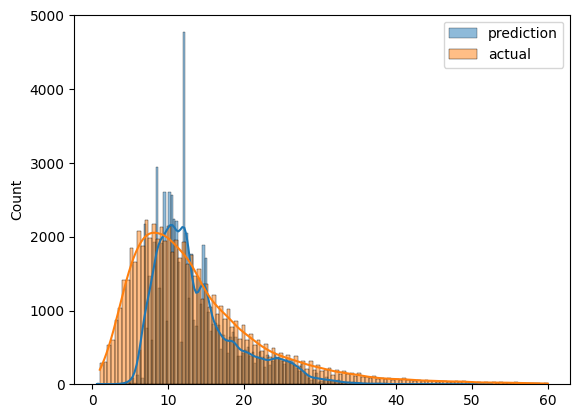

In [8]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [11]:
len(df_train), len(df_val)

(65946, 62574)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.037803764245777

In [16]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "cecile")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")
    
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [19]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [27]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("developer", "cecile")
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        
        return {"loss": rmse, "status": STATUS_OK}

In [28]:
# http://hyperopt.github.io/hyperopt/getting-started/search_spaces/
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:00:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.57946                           
[1]	validation-rmse:6.57508                           
[2]	validation-rmse:6.02344                           
[3]	validation-rmse:5.73218                           
[4]	validation-rmse:5.57464                           
[5]	validation-rmse:5.49342                           
[6]	validation-rmse:5.44049                           
[7]	validation-rmse:5.40337                           
[8]	validation-rmse:5.37960                           
[9]	validation-rmse:5.36434                           
[10]	validation-rmse:5.35396                          
[11]	validation-rmse:5.34162                          
[12]	validation-rmse:5.33580                          
[13]	validation-rmse:5.32971                          
[14]	validation-rmse:5.32155                          
[15]	validation-rmse:5.31505                          
[16]	validation-rmse:5.31286                          
[17]	validation-rmse:5.31049                          
[18]	valid

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:01:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.42589                                                    
[1]	validation-rmse:7.70499                                                    
[2]	validation-rmse:7.13152                                                    
[3]	validation-rmse:6.67888                                                    
[4]	validation-rmse:6.32479                                                    
[5]	validation-rmse:6.04965                                                    
[6]	validation-rmse:5.84326                                                    
[7]	validation-rmse:5.68059                                                    
[8]	validation-rmse:5.55723                                                    
[9]	validation-rmse:5.46893                                                    
[10]	validation-rmse:5.39979                                                   
[11]	validation-rmse:5.34707                                                   
[12]	validation-rmse:5.30666            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:02:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.43570                                                    
[1]	validation-rmse:6.35546                                                    
[2]	validation-rmse:5.77276                                                    
[3]	validation-rmse:5.47676                                                    
[4]	validation-rmse:5.32984                                                    
[5]	validation-rmse:5.25600                                                    
[6]	validation-rmse:5.21817                                                    
[7]	validation-rmse:5.19821                                                    
[8]	validation-rmse:5.18948                                                    
[9]	validation-rmse:5.18329                                                    
[10]	validation-rmse:5.17930                                                   
[11]	validation-rmse:5.17725                                                   
[12]	validation-rmse:5.17726            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:03:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.26821                                                    
[1]	validation-rmse:7.47107                                                    
[2]	validation-rmse:6.87915                                                    
[3]	validation-rmse:6.44567                                                    
[4]	validation-rmse:6.13192                                                    
[5]	validation-rmse:5.90909                                                    
[6]	validation-rmse:5.74899                                                    
[7]	validation-rmse:5.63400                                                    
[8]	validation-rmse:5.55410                                                    
[9]	validation-rmse:5.49199                                                    
[10]	validation-rmse:5.45039                                                   
[11]	validation-rmse:5.41833                                                   
[12]	validation-rmse:5.39276            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:04:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.49650                                                    
[1]	validation-rmse:5.46537                                                    
[2]	validation-rmse:5.44358                                                    
[3]	validation-rmse:5.42708                                                    
[4]	validation-rmse:5.41224                                                    
[5]	validation-rmse:5.40607                                                    
[6]	validation-rmse:5.39999                                                    
[7]	validation-rmse:5.39281                                                    
[8]	validation-rmse:5.38811                                                    
[9]	validation-rmse:5.36498                                                    
[10]	validation-rmse:5.36034                                                   
[11]	validation-rmse:5.35531                                                   
[12]	validation-rmse:5.34550            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:05:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.84839                                                    
[1]	validation-rmse:5.83200                                                    
[2]	validation-rmse:5.45433                                                    
[3]	validation-rmse:5.30977                                                    
[4]	validation-rmse:5.24819                                                    
[5]	validation-rmse:5.22284                                                    
[6]	validation-rmse:5.20529                                                    
[7]	validation-rmse:5.19460                                                    
[8]	validation-rmse:5.18745                                                    
[9]	validation-rmse:5.18308                                                    
[10]	validation-rmse:5.17971                                                   
[11]	validation-rmse:5.17753                                                   
[12]	validation-rmse:5.17712            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:05:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92831                                                    
[1]	validation-rmse:8.56800                                                    
[2]	validation-rmse:8.23969                                                    
[3]	validation-rmse:7.94072                                                    
[4]	validation-rmse:7.66830                                                    
[5]	validation-rmse:7.42140                                                    
[6]	validation-rmse:7.19789                                                    
[7]	validation-rmse:6.99611                                                    
[8]	validation-rmse:6.81412                                                    
[9]	validation-rmse:6.65015                                                    
[10]	validation-rmse:6.50269                                                   
[11]	validation-rmse:6.37057                                                   
[12]	validation-rmse:6.25269            

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:08:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85241                                                      
[1]	validation-rmse:8.42959                                                      
[2]	validation-rmse:8.04991                                                      
[3]	validation-rmse:7.70993                                                      
[4]	validation-rmse:7.40629                                                      
[5]	validation-rmse:7.13647                                                      
[6]	validation-rmse:6.89685                                                      
[7]	validation-rmse:6.68517                                                      
[8]	validation-rmse:6.49807                                                      
[9]	validation-rmse:6.33297                                                      
[10]	validation-rmse:6.18778                                                     
[11]	validation-rmse:6.05958                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:10:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98844                                                       
[1]	validation-rmse:8.68002                                                       
[2]	validation-rmse:8.39533                                                       
[3]	validation-rmse:8.13289                                                       
[4]	validation-rmse:7.89120                                                       
[5]	validation-rmse:7.66918                                                       
[6]	validation-rmse:7.46533                                                       
[7]	validation-rmse:7.27855                                                       
[8]	validation-rmse:7.10774                                                       
[9]	validation-rmse:6.95154                                                       
[10]	validation-rmse:6.80899                                                      
[11]	validation-rmse:6.67887                                                      
[12]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:15:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.98137                                                       
[1]	validation-rmse:5.44654                                                       
[2]	validation-rmse:5.33705                                                       
[3]	validation-rmse:5.30429                                                       
[4]	validation-rmse:5.28798                                                       
[5]	validation-rmse:5.27258                                                       
[6]	validation-rmse:5.27265                                                       
[7]	validation-rmse:5.25343                                                       
[8]	validation-rmse:5.25148                                                       
[9]	validation-rmse:5.24632                                                       
[10]	validation-rmse:5.24403                                                      
[11]	validation-rmse:5.24028                                                      
[12]

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:16:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.54320                                                        
[1]	validation-rmse:5.32341                                                        
[2]	validation-rmse:5.30754                                                        
[3]	validation-rmse:5.30501                                                        
[4]	validation-rmse:5.30256                                                        
[5]	validation-rmse:5.29302                                                        
[6]	validation-rmse:5.28677                                                        
[7]	validation-rmse:5.28702                                                        
[8]	validation-rmse:5.28641                                                        
[9]	validation-rmse:5.28175                                                        
[10]	validation-rmse:5.27734                                                       
[11]	validation-rmse:5.27796                                                

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:16:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.33047                                                     
[1]	validation-rmse:7.55829                                                     
[2]	validation-rmse:6.98182                                                     
[3]	validation-rmse:6.51745                                                     
[4]	validation-rmse:6.19578                                                     
[5]	validation-rmse:5.95116                                                     
[6]	validation-rmse:5.77757                                                     
[7]	validation-rmse:5.65034                                                     
[8]	validation-rmse:5.55421                                                     
[9]	validation-rmse:5.47929                                                     
[10]	validation-rmse:5.42740                                                    
[11]	validation-rmse:5.39424                                                    
[12]	validation-rmse:5.35961

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:17:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.73228                                                     
[1]	validation-rmse:5.44045                                                     
[2]	validation-rmse:5.37906                                                     
[3]	validation-rmse:5.35067                                                     
[4]	validation-rmse:5.32838                                                     
[5]	validation-rmse:5.32089                                                     
[6]	validation-rmse:5.31607                                                     
[7]	validation-rmse:5.31171                                                     
[8]	validation-rmse:5.31179                                                     
[9]	validation-rmse:5.30666                                                     
[10]	validation-rmse:5.30394                                                    
[11]	validation-rmse:5.29544                                                    
[12]	validation-rmse:5.29411

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:18:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.52953                                                     
[1]	validation-rmse:5.23510                                                     
[2]	validation-rmse:5.21114                                                     
[3]	validation-rmse:5.20615                                                     
[4]	validation-rmse:5.20259                                                     
[5]	validation-rmse:5.20120                                                     
[6]	validation-rmse:5.19884                                                     
[7]	validation-rmse:5.19820                                                     
[8]	validation-rmse:5.19596                                                     
[9]	validation-rmse:5.18650                                                     
[10]	validation-rmse:5.18637                                                    
[11]	validation-rmse:5.18443                                                    
[12]	validation-rmse:5.18674

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:18:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.41946                                                     
[1]	validation-rmse:5.33207                                                     
[2]	validation-rmse:5.32375                                                     
[3]	validation-rmse:5.30439                                                     
[4]	validation-rmse:5.29432                                                     
[5]	validation-rmse:5.28672                                                     
[6]	validation-rmse:5.28009                                                     
[7]	validation-rmse:5.26285                                                     
[8]	validation-rmse:5.25570                                                     
[9]	validation-rmse:5.25269                                                     
[10]	validation-rmse:5.24644                                                    
[11]	validation-rmse:5.24522                                                    
[12]	validation-rmse:5.24339

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:18:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.52822                                                     
[1]	validation-rmse:5.24516                                                     
[2]	validation-rmse:5.22430                                                     
[3]	validation-rmse:5.21677                                                     
[4]	validation-rmse:5.20826                                                     
[5]	validation-rmse:5.19574                                                     
[6]	validation-rmse:5.19002                                                     
[7]	validation-rmse:5.18823                                                     
[8]	validation-rmse:5.18631                                                     
[9]	validation-rmse:5.18236                                                     
[10]	validation-rmse:5.18575                                                    
[11]	validation-rmse:5.18227                                                    
[12]	validation-rmse:5.18286

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:19:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00997                                                     
[1]	validation-rmse:8.72054                                                     
[2]	validation-rmse:8.45088                                                     
[3]	validation-rmse:8.20204                                                     
[4]	validation-rmse:7.96879                                                     
[5]	validation-rmse:7.75295                                                     
[6]	validation-rmse:7.55377                                                     
[7]	validation-rmse:7.36544                                                     
[8]	validation-rmse:7.19586                                                     
[9]	validation-rmse:7.03671                                                     
[10]	validation-rmse:6.89214                                                    
[11]	validation-rmse:6.75916                                                    
[12]	validation-rmse:6.63693

/workspaces/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:21:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.89920                                                     
[1]	validation-rmse:6.94469                                                     
[2]	validation-rmse:6.34196                                                     
[3]	validation-rmse:5.94061                                                     
[4]	validation-rmse:5.69127                                                     
[5]	validation-rmse:5.54232                                                     
[6]	validation-rmse:5.44685                                                     
[7]	validation-rmse:5.39533                                                     
[8]	validation-rmse:5.35724                                                     
[9]	validation-rmse:5.33961                                                     
[10]	validation-rmse:5.31712                                                    
[11]	validation-rmse:5.30422                                                    
[12]	validation-rmse:5.29527

In [ ]:
# https://mlflow.org/docs/latest/tracking/autolog.html
params = {
    'max_depth': 
    'learning_rate': 
    'reg_alpha': 
    'reg_lambda': 
    'min_child_weight': 
    'objective':
    'seed': 42
}


mlflow.xgboost.autolog()

booster = xgb.train(
    params = params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)